# **# Using GRADCAM find the Sunglasses**

Let's start with a pretrained VGG model

In [1]:
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

Using TensorFlow backend.


1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [2]:
model = VGG16(weights="imagenet")
from skimage import io
dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(dog)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
model.summary()





553467904/553467096 [==============================] - 35s 0us/step






Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________

1. We get the predictions for the image
2. We take the topmost class index
3. Take output from the final convolutional layer

In [3]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")


153


1. Compute the gradient of the class output value with respect to the feature map
2. Pool the gradients over all the axies leaving out the channel dimension
3. Weigh the output feature map with the computed gradient values

In [4]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


1. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14 
2. Normalize the heat map to make the values between 0 and 1

In [5]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


Show the results

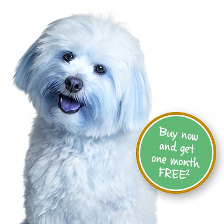

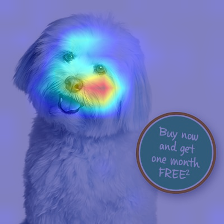

In [6]:
heatmap = cv2.resize(heatmap, (dog.shape[1], dog.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(dog, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( dog)
cv2_imshow(superimposed_img)

1.   Implementing the GRADCAM on One Layer Before the Last Layer

In [0]:
lasttolast_conv_layer = model.get_layer("block5_conv2")


In [8]:
grads_1 = K.gradients(class_output, lasttolast_conv_layer.output)[0]
print(grads_1.shape)
pooled_grads_1 = K.mean(grads_1, axis=(0, 1, 2))
print(pooled_grads_1.shape)
iterate1 = K.function([model.input], [pooled_grads_1, lasttolast_conv_layer.output[0]])

pooled_grads_value1, conv_layer_output_value1 = iterate1([x])

for i in range(512):
  conv_layer_output_value1[:, :, i] *= pooled_grads_value1[i]

(?, 14, 14, 512)
(512,)


In [9]:
heatmap = np.mean(conv_layer_output_value1, axis = -1)
print(conv_layer_output_value1.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


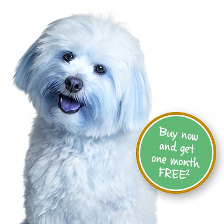

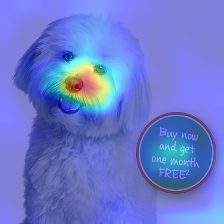

In [10]:
heatmap = cv2.resize(heatmap, (dog.shape[1], dog.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(dog, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( dog)
cv2_imshow(superimposed_img)

2.   Implementing the GRADCAM on another One Layer Before the Last Layer



In [0]:
lasttolastone_conv_layer = model.get_layer("block5_conv1")

In [12]:
grads_2 = K.gradients(class_output, lasttolastone_conv_layer.output)[0]
print(grads_2.shape)
pooled_grads_2 = K.mean(grads_2, axis=(0, 1, 2))
print(pooled_grads_2.shape)
iterate2 = K.function([model.input], [pooled_grads_2, lasttolastone_conv_layer.output[0]])

pooled_grads_value2, conv_layer_output_value2 = iterate2([x])

for i in range(512):
  conv_layer_output_value2[:, :, i] *= pooled_grads_value2[i]

(?, 14, 14, 512)
(512,)


In [13]:
heatmap = np.mean(conv_layer_output_value2, axis = -1)
print(conv_layer_output_value2.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


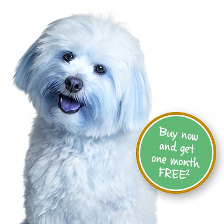

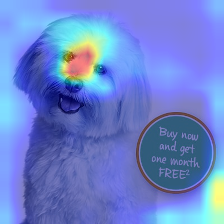

In [14]:
heatmap = cv2.resize(heatmap, (dog.shape[1], dog.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(dog, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( dog)
cv2_imshow(superimposed_img)

# **Finding Sunglasses on the face on Tony Stark Image**

Mount Google Drive to Import the test images

In [15]:
!pip install pydrive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
tony = io.imread("/content/gdrive/My Drive/Colab Notebooks/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg")

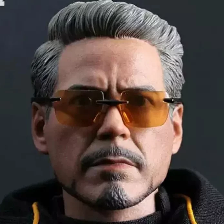

In [17]:
tony = cv2.resize(tony, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
cv2_imshow(cv2.cvtColor(tony, cv2.COLOR_BGR2RGB))

In [0]:
x = image.img_to_array(tony)
x = np.expand_dims(x, axis=0)

In [0]:
x = preprocess_input(x)

In [24]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

837


In [25]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)

pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


In [26]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)

# Normalize
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap = cv2.resize(heatmap, (tony.shape[1], tony.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

(14, 14, 512)
(14, 14)


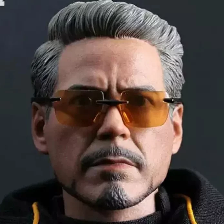

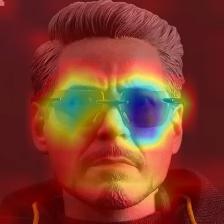

In [27]:
superimposed_img = cv2.addWeighted(tony, 0.5, heatmap, 0.5, 0)

cv2_imshow(cv2.cvtColor(tony, cv2.COLOR_BGR2RGB))
cv2_imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))

# **Conclusion:**

Could find the Sunglasses with the class ID: 837